## beautifulsoup & newspaper3k drawling

In [3]:
from bs4 import BeautifulSoup
from newspaper import Article

#- 파싱할 뉴스 기사 주소입니다.
url = 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002881076'

#- 언어가 한국어이므로 language='ko'로 설정해줍니다.
article = Article(url, language='ko')
article.download()
article.parse()

In [ ]:
#- 기사 제목을 출력합니다.
print('기사 제목 :')
print(article.title)
print('')

#- 기사 내용을 출력합니다.
print('기사 내용 :')
print(article.text)

In [4]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [5]:
#. 한 페이지당 뉴스 기사가 20개임을 감안하여 총 40개의 url리스트 받아오기
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [6]:
#. 5개만 출력해 보기
url_list[:5]

['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451723',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451721',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451718',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009849190',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451717']

In [7]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [8]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

경제 카테고리(코드 101)의 40개의 URL 리스트로부터 데이터프레임을 생성

In [9]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


## 3-8. 네이버 뉴스 기사 크롤링 (3) 데이터 수집 및 전처리
여러 카테고리에 뉴스들도 수집해보기 -> 특저 날짜의 사회, 생활/문화, IT/과학

In [10]:
# 수집을 원하는 카테고리 코드를을 저장한 리스트를 만들어두기
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [11]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [12]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [13]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  60


In [ ]:
# n v a <- exclude all. or extract n
# 60개중 임의의 10개 샘플 선택하여 출력
df.sample(10)

## 대량크롤링


In [15]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

In [16]:
# 크롤링한 뉴스 기사의 양이 많으므로 실수로 유실하지 않도록 csv 파일로 별도 저장

import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/aiffel/aiffel/news_crawler/news_data.csv File Saved!


### 3-9. naver news article crawling (4) data preprocessing\
데이터를 가공/정제하여 모델의 훈련에 사용하기 좋은 숫자의 형태로 바꿔준다

In [32]:
#. 저장해둔 csv파일을 다시 읽어서 dataframe으로 저장하기 위한 코드
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [33]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0     파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1     동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2     황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3     귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4     서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
5     질서정연 코로나 확산 방지를 위한 물리적 거리 두기가 생활 속 거리 두기로 전환된 ...
6     코로나에 걸렸다 나은 친구는 아무래도 좀 멀리하게 될 것 같아요 재발 가능성 때문에...
7     년 메이저리그  다저스의 시즌 마지막 경기였다 신인 타자 더스티 베이커현 휴스턴 애...
8     일 등교수업을 앞둔 경북 한 학교의 보건실에는 손소독제 마스크 등 방역물품이 상자째...
9     경찰 로고뉴스   신채린 기자 경찰 로고뉴스   신채린 기자서울뉴스 이상학 기자  ...
10    안병용 의정부시장 이천화재 희생자 합동분향소 헌화 사진제공의정부시 안병용 의정부시장...
11    이재용 삼성전자 부회장의 일 대국민 사과가 그를 상대로 한 수사재판에 어떤 영향을 ...
12    동영상 뉴스앵커다음 주 고등학교 학년부터 순차적인 등교수업이 시작되는데 교실 방역에...
13    명의 사망자가 발생한 경기 이천 물류창고 화재 현장에서 일 경찰과 소방 등 관계기관...
14    동영상 뉴스앵커코로나 신규 확진자가 명 발생해 일 만에 최저치를 기록했습니다방역 당...
15    뉴스  뉴스 서울뉴스 이상학 기자  밤에 귀가하던 여성에게 성범죄를 시도한 대 남성...
16    메건 마클 왕자비와 아들 아치의 모습세이브더칠드런 인스타그램 캡처 재판매 및  금지...
17    국내 최초로 건립되는 노동문학관이 일 첫 삽을 떴다노동문학관건립위원회위원장 

In [34]:
# data에 null값이 있진 않은지 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [35]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  53


데이터 탐색
---
각 카테고리별 샘플 분포 확인 -> matplotlib에 한글폰트 적용안될 수 있음 주의
[matplotlib 한글폰트 설정방법](https://followers.tistory.com/26)

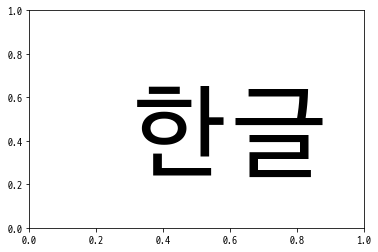

In [36]:
#. 한글 출력
import matplotlib.pyplot as plt
plt.text(0.3, 0.3, '한글', size=100)

from matplotlib import font_manager as fm
font_location='/home/aiffel/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524-ligature.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
plt.rc('font',family=font_name)

<AxesSubplot:>

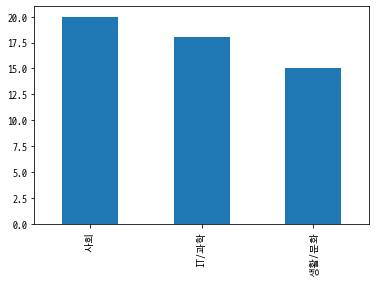

In [37]:
df['code'].value_counts().plot(kind = 'bar')

In [38]:
# 실 개수 확인
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     18
1     사회     20
2  생활/문화     15


### 토큰화
자연어 처리 - 문자열은 특정 단위로 나누어지는데 이 특정 단위가 바로 토큰이다
토크나이징 - 문자열을 토큰으로 break down into pieces
[영어와 한국어의 토큰화의 차이](https://wikidocs.net/21698)   
-> 한국어 자연어처리의 경우에는 토큰화 과정을 주로 형태소 분석기를 사용해서 수행    
한국어의 경우 교착어라는 특성으로 인해 조사, 어미 등이 붙어있어 띄어쓰기 단위로
토큰화를 할 경우에는 같은 단어임에도 다른 단어로 인식될 수 있다.

In [39]:
# 형태소 패키지 라이브러리 Mecab
# Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나눠줌
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


자연어 처리: 토큰화 결과가 얼마나 정확한지에 다라 그 성능에 많은 영향을 받는다    
형태소 분석기의 결과가 머신러닝 결과의 성능에 큰 영향을 주기도 한다

### 불용어 제거(stopwords)
토큰화 전처리 필수과정 - 불필요한 토큰들을 제거하는 불용어 제거     


In [40]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

불용어 - 미리 짐작하여 한 번에 정의한는 것이 아니라 토큰화 과정을 거친 결과를 지속적으로 확인하면서 계속 추가하게 되는게 일반적이다

In [41]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [42]:
# 전체 데이터에 대해서 토큰화 및 불용어 제거를 수행한 뒤 첫 번째 샘플을 출력
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [46]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

In [47]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 39
테스트용 뉴스 기사의 개수 :  14
훈련용 레이블의 개수 :  39
테스트용 레이블의 개수 :  14


기계는 텍스트보다 숫자를 더 잘 처리한다    
ML모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있다    
TF-IDF 방법 사용

### 각 뉴스 문서를 TF-IDF 벡터로 바꾼 뒤 나이브 베이즈 분류기를 학습

`fit_transform()` 함수는 fit, transform을 연이어 수행하는 함수로, `CountVectorizer.fit_transform()` 은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 준다
[사이킷런 참고자료](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [49]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트 하기

# 텍스트 입력을 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수 만들기
# 이걸로 바로 txt -> 나이브 베이즈 분류기 입력으로 사용함으로써 용이한 테스트 가능

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [2]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

NameError: name 'text_data' is not defined